In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
funnel=pd.read_excel("Intern Hiring Assignment Data.xlsx",sheet_name="Funnel")
funnel

,Year,Month,Customer Segment,Region,KPI,Value Type,Value
0,2020,12,Clients,India,Lv1_Visitors,Actuals,1354648.0
1,2020,12,Clients,India,Lv2_Visitors,Actuals,2689569.0
2,2020,12,Clients,India,Lv3_Visitors,Actuals,1300571.0
3,2020,12,Clients,India,Lv4_Visitors,Actuals,NaN
4,2020,12,Clients,India,Lv3_Visitors,Actuals,706677.0
...,...,...,...,...,...,...,...
1567,2022,1,Customers,Dehradun,Lv5_Visitors,Actuals,1693.0
1568,2022,1,Customers,Aurangabad,Lv4_Visitors,Actuals,1428.0
1569,2022,1,Customers,Ujjain,Lv5_Visitors,Actuals,1311.0
1570,2022,1,Customers,Faridabad,Lv5_Visitors,Actuals,1071.0


In [3]:
abtest=pd.read_excel("Intern Hiring Assignment Data.xlsx",sheet_name="ABTest")
abtest

,Months (Date),Date,Variants,DeviceType,Sum of Clicks,Sum of Visitors
0,Mar,2023-03-29,Control,Desktop,31312,298032
1,Mar,2023-03-29,Control,Mobile,18399,192144
2,Mar,2023-03-29,Control,Others,34,375
3,Mar,2023-03-29,Control,Tablet,660,7646
4,Mar,2023-03-29,Treatment,Desktop,10067,32737
...,...,...,...,...,...,...
139,Apr,2023-04-15,Control,Tablet,676,6638
140,Apr,2023-04-15,Treatment,Desktop,5260,21292
141,Apr,2023-04-15,Treatment,Mobile,2958,19269
142,Apr,2023-04-15,Treatment,Others,3,37


In [4]:
funnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              1572 non-null   int64  
 1   Month             1572 non-null   int64  
 2   Customer Segment  1572 non-null   object 
 3   Region            1572 non-null   object 
 4   KPI               1572 non-null   object 
 5   Value Type        1572 non-null   object 
 6   Value             1547 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 86.1+ KB


In [5]:
funnel.value_counts()

Year  Month  Customer Segment  Region     KPI           Value Type  Value    
2020  1      Clients           India      Lv1_Visitors  Actuals     3322789.0    1
2022  4      Clients           Indore     Lv2_Visitors  Actuals     63090.0      1
      3      Customers         India      Lv1_Visitors  Actuals     578083.0     1
                               Faridabad  Lv5_Visitors  Actuals     1524.0       1
                                          Lv4_Visitors  Actuals     5967.0       1
                                                                                ..
2021  2      Customers         Uddepy     Lv4_Visitors  Actuals     42753.0      1
                                          Lv3_Visitors  Actuals     88016.0      1
                                          Lv2_Visitors  Actuals     87365.0      1
                                          Lv1_Visitors  Actuals     114704.0     1
2022  12     Customers         Ujjain     Lv5_Visitors  Actuals     293.0        1
Name: cou

In [6]:
for kpi in funnel['KPI'].unique():
    mean = funnel[funnel['KPI'] == kpi]['Value'].mean()
    median = funnel[funnel['KPI'] == kpi]['Value'].median()
    print(f"For KPI {kpi}, Mean: {mean}, Median: {median}")

For KPI Lv1_Visitors, Mean: 544273.1833333333, Median: 78694.5
For KPI Lv2_Visitors, Mean: 367219.31740614335, Median: 51787.0
For KPI Lv3_Visitors, Mean: 285153.8264984227, Median: 50636.0
For KPI Lv4_Visitors, Mean: 127959.91693290735, Median: 26418.0
For KPI Lv5_Visitors, Mean: 43758.41358024691, Median: 7757.0


In [7]:
# train_data = funnel[funnel['Value'].notnull()]
# predict_data = funnel[funnel['Value'].isnull()]

# X_train, X_val, y_train, y_val = train_test_split(train_data.drop('Value', axis=1), 
#                                                   train_data['Value'], 
#                                                   test_size=0.2, 
#                                                   random_state=42)

# train_pool = Pool(data=X_train, label=y_train, cat_features=["Customer Segment","Region","Value Type"])
# val_pool = Pool(data=X_val, label=y_val, cat_features=["Customer Segment","Region","Value Type"])

# model = CatBoostRegressor()

# grid = {'iterations': [100, 200, 300],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'depth': [4, 6, 8],
#         'l2_leaf_reg': [1, 3, 5]}

# result = model.grid_search(grid, train_pool, plot=True, verbose=False)

# print(result['params'])
# print(min(result['cv_results']['test-RMSE-mean']))

In [8]:
# Split the data
train_data = funnel[funnel['Value'].notnull()]
predict_data = funnel[funnel['Value'].isnull()]

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('Value', axis=1), 
                                                  train_data['Value'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# Create Pool objects for train and validation sets
train_pool = Pool(data=X_train, label=y_train, cat_features=["Customer Segment","Region","KPI","Value Type"])
val_pool = Pool(data=X_val, label=y_val, cat_features=["Customer Segment","Region","KPI","Value Type"])

#Best Params
best_params={'depth': 8, 'l2_leaf_reg': 5, 'iterations': 300, 'learning_rate': 0.1}

# Initialize the model
model = CatBoostRegressor(**best_params)

# Fit the model with the best parameters
model.fit(train_pool)

# Predict the missing values
predict_data['Value'] = model.predict(predict_data.drop('Value', axis=1))

0:	learn: 607201.6507201	total: 217ms	remaining: 1m 4s
1:	learn: 559407.5398470	total: 275ms	remaining: 41s
2:	learn: 519131.7736102	total: 327ms	remaining: 32.4s
3:	learn: 483532.6377257	total: 361ms	remaining: 26.7s
4:	learn: 450360.0178963	total: 418ms	remaining: 24.6s
5:	learn: 421451.5644023	total: 491ms	remaining: 24s
6:	learn: 391337.2023592	total: 543ms	remaining: 22.7s
7:	learn: 367184.6024983	total: 606ms	remaining: 22.1s
8:	learn: 345752.3479016	total: 657ms	remaining: 21.3s
9:	learn: 326454.8684137	total: 731ms	remaining: 21.2s
10:	learn: 309840.8235394	total: 794ms	remaining: 20.9s
11:	learn: 297014.9029578	total: 867ms	remaining: 20.8s
12:	learn: 285187.8675464	total: 901ms	remaining: 19.9s
13:	learn: 272066.1861449	total: 963ms	remaining: 19.7s
14:	learn: 259879.4224362	total: 1.03s	remaining: 19.5s
15:	learn: 251517.4214355	total: 1.09s	remaining: 19.3s
16:	learn: 244300.2390128	total: 1.15s	remaining: 19.2s
17:	learn: 235052.6695535	total: 1.22s	remaining: 19.2s
18:	le

In [9]:
pd.options.display.float_format = '{:.2f}'.format

In [10]:
complete_data = pd.concat([train_data, predict_data])

In [11]:
complete_data[funnel["Value"].isna()]

,Year,Month,Customer Segment,Region,KPI,Value Type,Value
3,2020,12,Clients,India,Lv4_Visitors,Actuals,338507.36
132,2021,9,Clients,India,Lv2_Visitors,Actuals,1962548.23
133,2021,9,Clients,India,Lv3_Visitors,Actuals,727877.66
166,2020,8,Clients,India,Lv3_Visitors,Actuals,1194743.70
175,2021,8,Clients,India,Lv4_Visitors,Actuals,380910.45
257,2021,6,Clients,India,Lv3_Visitors,Actuals,732035.57
331,2020,4,Clients,India,Lv4_Visitors,Actuals,661626.45
381,2021,3,Clients,India,Lv3_Visitors,Actuals,998898.51
454,2020,1,Clients,India,Lv3_Visitors,Actuals,1287166.79
463,2021,1,Clients,India,Lv3_Visitors,Actuals,1269541.75


In [12]:
complete_data["Value"].std(),funnel["Value"].std()

(643190.3088432373, 644440.5529114249)

In [13]:
complete_data["Value"].mean(),funnel["Value"].mean()

(271595.57419569744, 268584.4589528119)

In [14]:
complete_data.shape,funnel.shape

((1572, 7), (1572, 7))

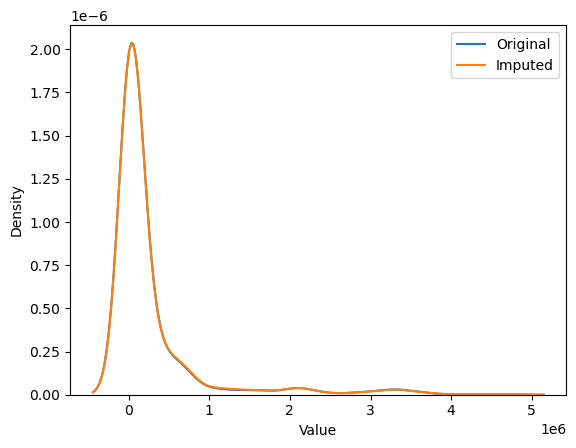

In [19]:
# Plot the KDE of 'Value' in the original data
sns.kdeplot(funnel['Value'], label='Original')
# Plot the KDE of 'Value' in the complete data
sns.kdeplot(complete_data['Value'], label='Imputed')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [26]:
funnel=complete_data

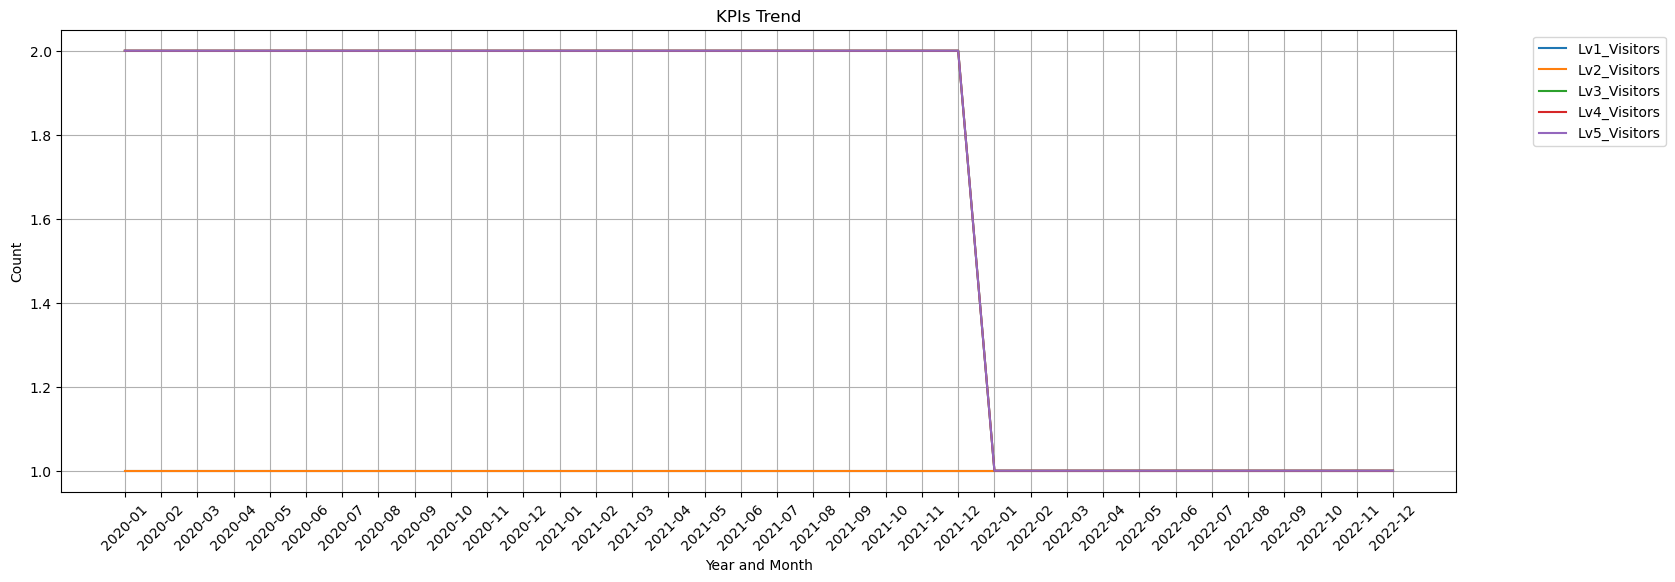

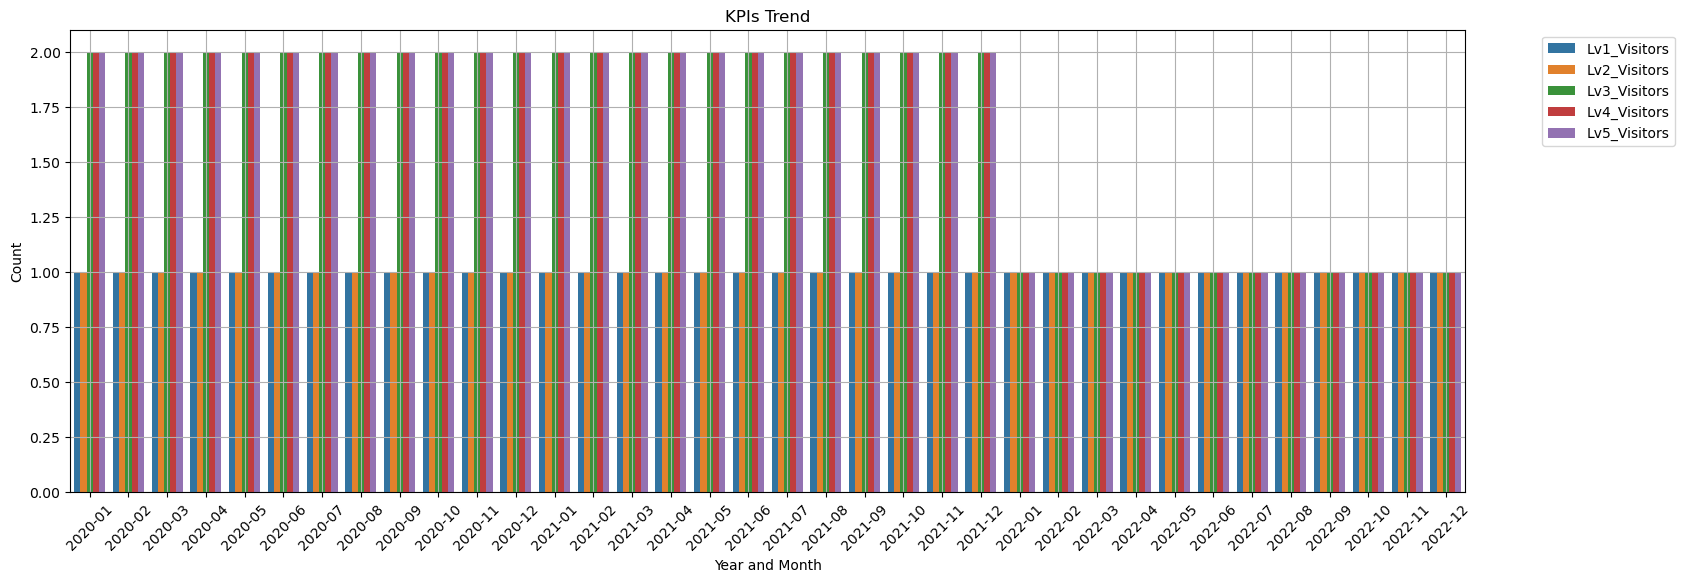

In [31]:
def plot_kpi_trends(data, region, customer_segment, start_year, start_month, end_year, end_month):
    # Filter the data based on the input parameters
    filtered_data = data[(data['Region'] == region) & 
                         (data['Customer Segment'] == customer_segment) & 
                         (data['Year'] >= start_year) & 
                         (data['Year'] <= end_year) & 
                         (data['Month'] >= start_month) & 
                         (data['Month'] <= end_month)]
    
    # Create a new column for year and month
    filtered_data['YearMonth'] = pd.to_datetime(filtered_data[['Year', 'Month']].assign(day=1))
    
    # Convert 'YearMonth' to string type
    filtered_data['YearMonth'] = filtered_data['YearMonth'].dt.strftime('%Y-%m')
    
    # Aggregate the data by 'YearMonth' and 'KPI'
    aggregated_data = filtered_data.groupby(['YearMonth', 'KPI']).size().reset_index(name='Count')

    # Sort 'YearMonth'
    aggregated_data.sort_values('YearMonth', inplace=True)

    # Determine figure size
    num_dates = aggregated_data['YearMonth'].nunique()
    fig_width = max(10, num_dates // 2)

    # Plot line graph
    plt.figure(figsize=(fig_width, 6))
    sns.lineplot(x='YearMonth', y='Count', hue='KPI', data=aggregated_data)
    plt.title('KPIs Trend')
    plt.xlabel('Year and Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Plot bar graph
    plt.figure(figsize=(fig_width, 6))
    sns.barplot(x='YearMonth', y='Count', hue='KPI', data=aggregated_data)
    plt.title('KPIs Trend')
    plt.xlabel('Year and Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function with your parameters
plot_kpi_trends(funnel, 'India', 'Clients', 2020, 1, 2022, 12)